Dataset shape: (8124, 23)
Dataset sample:
    class  cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0      1          5            2          4        1     6                1   
1      0          5            2          9        1     0                1   
2      0          0            2          8        1     3                1   
3      1          5            3          8        1     6                1   
4      0          5            2          3        0     5                1   

   gill-spacing  gill-size  gill-color  ...  stalk-surface-below-ring  \
0             0          1           4  ...                         2   
1             0          0           4  ...                         2   
2             0          0           5  ...                         2   
3             0          1           5  ...                         2   
4             1          0           4  ...                         2   

   stalk-color-above-ring  stalk-color-belo

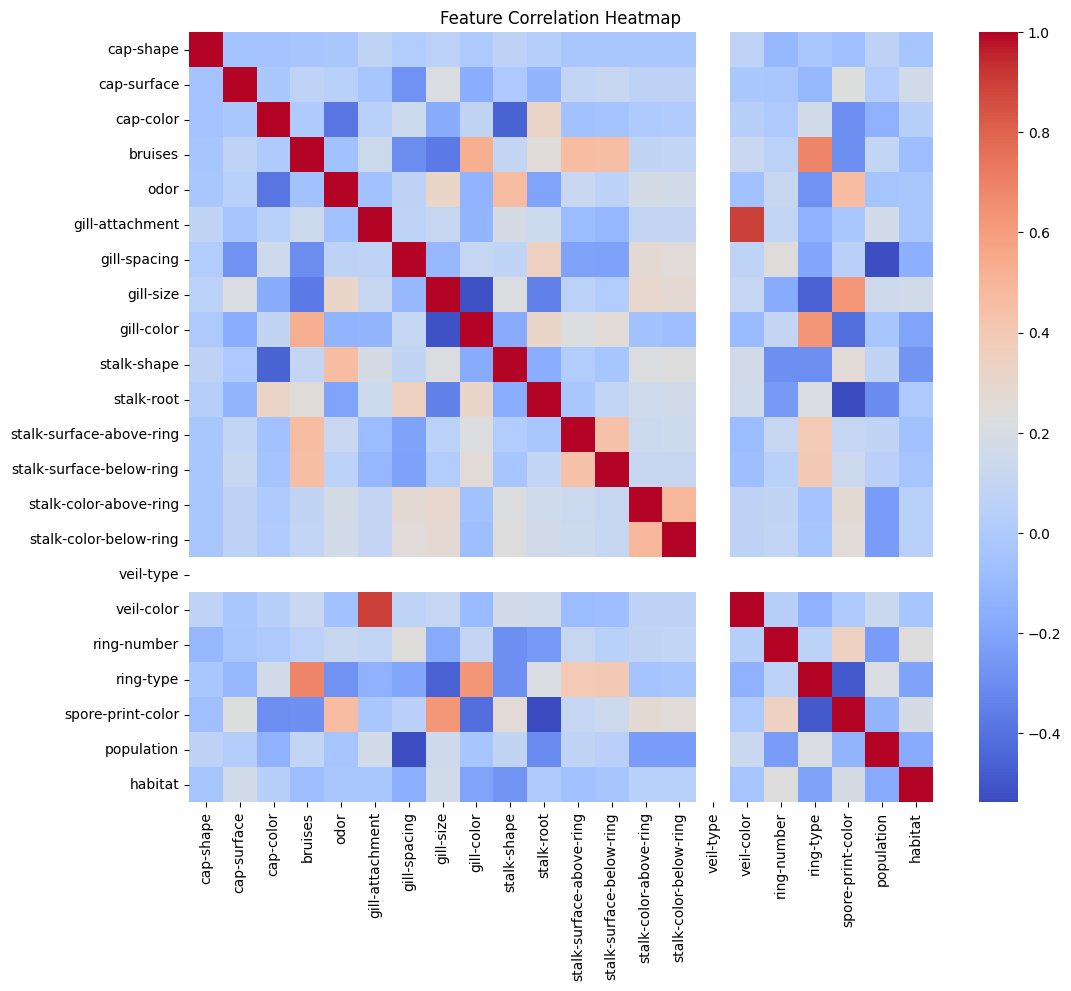

Best parameters found:
{'criterion': 'gini', 'max_depth': 7, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2}
Cross-validated training accuracy: 1.0000

Test Set Evaluation:
Test Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

      Edible       1.00      1.00      1.00       842
   Poisonous       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



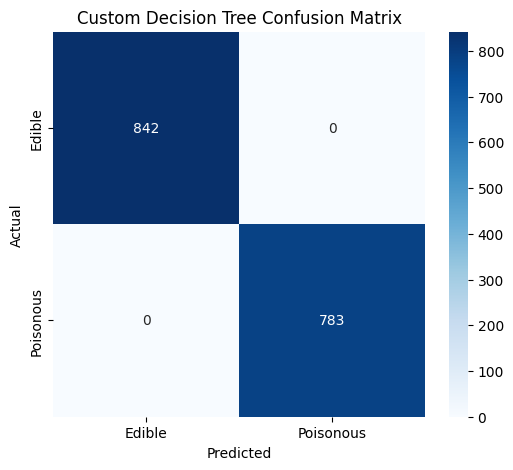

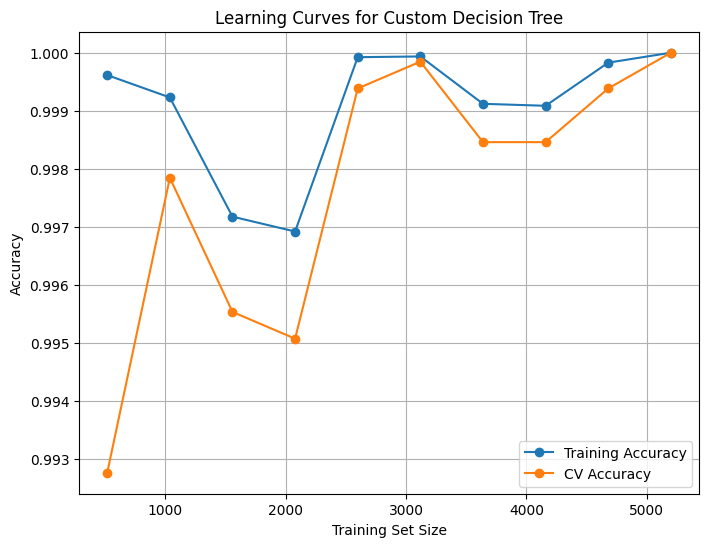

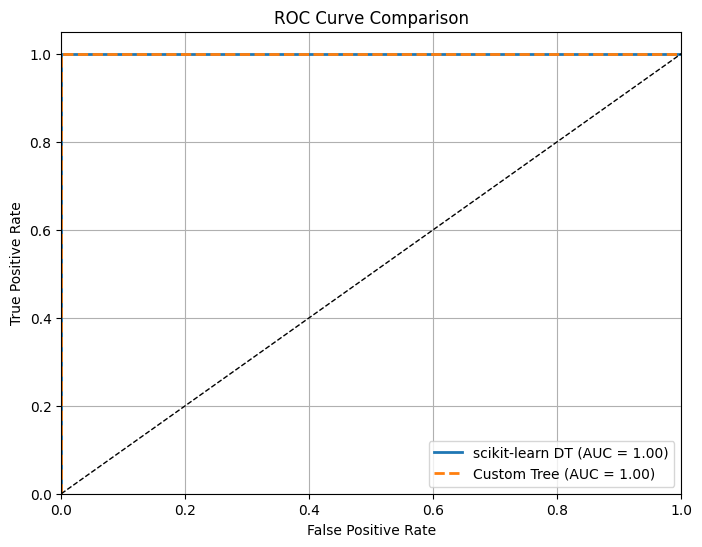

Brier score (scikit-learn DT): 0.0000
Brier score (Custom Tree): 0.0000


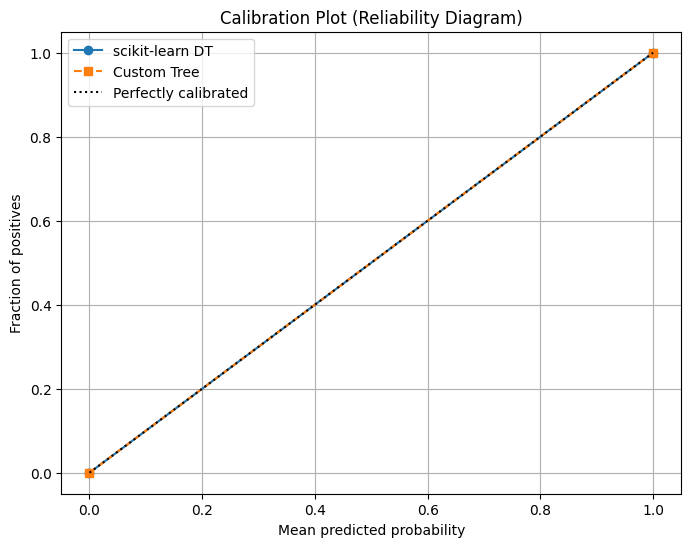

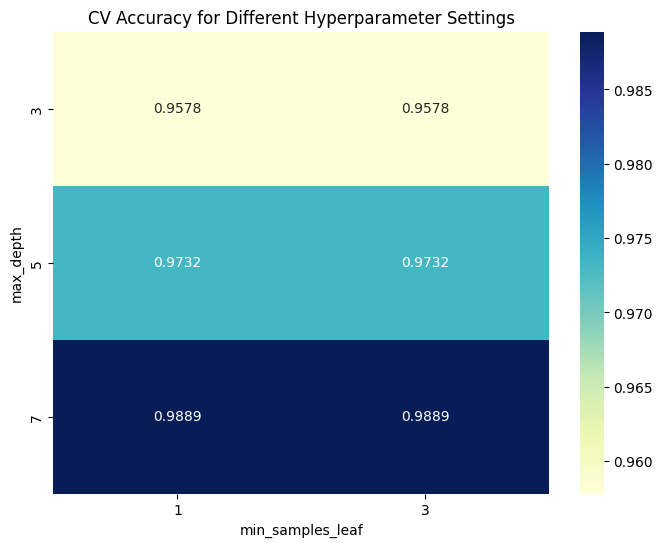

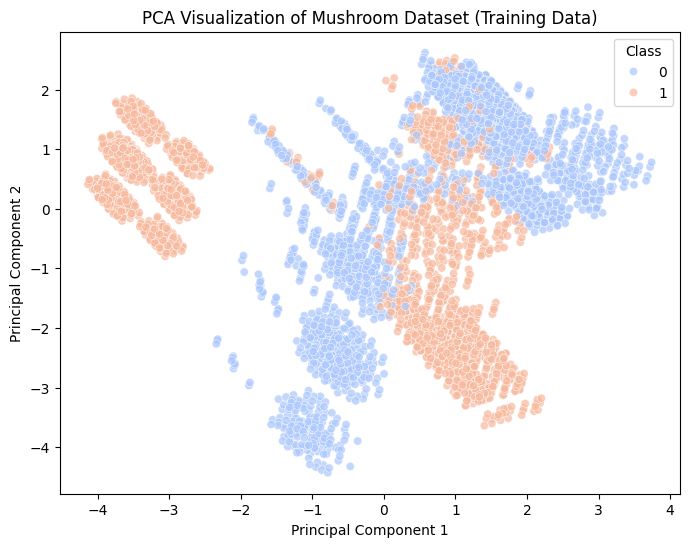


Feature Importances:
gill-color                  0.338633
spore-print-color           0.211014
population                  0.177561
gill-size                   0.122756
odor                        0.035568
bruises                     0.029587
stalk-shape                 0.023563
stalk-root                  0.016676
stalk-color-above-ring      0.015961
habitat                     0.014856
cap-color                   0.006773
cap-surface                 0.003883
stalk-surface-below-ring    0.001641
ring-number                 0.001528
veil-color                  0.000000
ring-type                   0.000000
cap-shape                   0.000000
veil-type                   0.000000
stalk-color-below-ring      0.000000
gill-spacing                0.000000
gill-attachment             0.000000
stalk-surface-above-ring    0.000000
dtype: float64


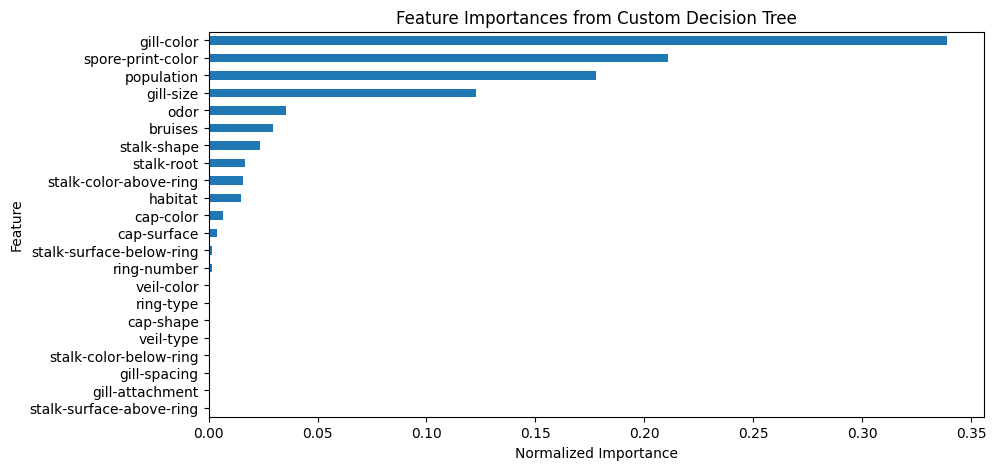


Final Tree Structure:
[X8 <= 3], Samples=6499
  [X20 <= 3], Samples=2646
    [X19 <= 1], Samples=474
      Leaf: Class=1, Samples=38, Counts=[ 0 38]
      [X7 <= 0], Samples=436
        Leaf: Class=0, Samples=414, Counts=[414   0]
        Leaf: Class=1, Samples=22, Counts=[ 0 22]
    [X10 <= 1], Samples=2172
      [X12 <= 0], Samples=2153
        [X1 <= 2], Samples=30
          Leaf: Class=1, Samples=21, Counts=[ 0 21]
          Leaf: Class=0, Samples=9, Counts=[9 0]
        Leaf: Class=1, Samples=2123, Counts=[   0 2123]
      Leaf: Class=0, Samples=19, Counts=[19  0]
  [X19 <= 1], Samples=3853
    [X4 <= 2], Samples=580
      Leaf: Class=1, Samples=515, Counts=[  0 515]
      Leaf: Class=0, Samples=65, Counts=[65  0]
    [X7 <= 0], Samples=3273
      [X13 <= 1], Samples=2756
        Leaf: Class=1, Samples=27, Counts=[ 0 27]
        [X2 <= 0], Samples=2729
          [X10 <= 0], Samples=34
            Leaf: Class=0, Samples=19, Counts=[19  0]
            Leaf: Class=1, Samples=15, Cou

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score,
                                     StratifiedKFold, learning_curve)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc, brier_score_loss)
from sklearn.tree import DecisionTreeClassifier  # For ROC and calibration comparison

warnings.filterwarnings("ignore")
logging.getLogger("lightgbm").setLevel(logging.CRITICAL)

# =============================================================================
# 1. Data Loading and Preprocessing
# =============================================================================
def load_data():
    """
    Load the Mushroom dataset from UCI repository and encode categorical features.
    """
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
    columns = ["class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", 
               "gill-attachment", "gill-spacing", "gill-size", "gill-color", "stalk-shape", 
               "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
               "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", 
               "ring-number", "ring-type", "spore-print-color", "population", "habitat"]
    df = pd.read_csv(url, header=None, names=columns)
    # Encode each column with LabelEncoder
    df = df.apply(LabelEncoder().fit_transform)
    return df

# Load and display basic info
df = load_data()
print("Dataset shape:", df.shape)
print("Dataset sample:\n", df.head())

X = df.drop("class", axis=1)
y = df["class"]

# Plot correlation heatmap for exploratory data analysis.
plt.figure(figsize=(12,10))
sns.heatmap(X.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Split into training and testing sets (with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =============================================================================
# 2. Custom Decision Tree Implementation from Scratch with Probability Estimates
# =============================================================================
class Node:
    def __init__(self, 
                 feature_index=None, 
                 threshold=None, 
                 left=None, 
                 right=None, 
                 *, 
                 value=None,
                 class_counts=None,
                 samples_count=None):
        """
        A node in the decision tree.
        
        Parameters:
        - feature_index: Index of feature used for splitting.
        - threshold: Threshold (or decision value) for the split.
        - left: Left child node.
        - right: Right child node.
        - value: Predicted class if the node is a leaf.
        - class_counts: Array of class counts at the node (for probability estimates).
        - samples_count: Number of samples reaching the node.
        """
        self.feature_index = feature_index  
        self.threshold = threshold  
        self.left = left  
        self.right = right  
        self.value = value  # if leaf, stores the majority class
        self.class_counts = class_counts  # counts of classes at this node
        self.samples_count = samples_count

    def is_leaf_node(self):
        return self.value is not None

class CustomDecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, 
                 max_depth=5, 
                 min_samples_split=2, 
                 min_samples_leaf=1, 
                 min_impurity_decrease=0.0,
                 criterion='gini'):
        """
        Custom Decision Tree for binary classification.
        
        Parameters:
        - max_depth: Maximum depth of the tree.
        - min_samples_split: Minimum samples required to split a node.
        - min_samples_leaf: Minimum samples required at a leaf.
        - min_impurity_decrease: Minimum impurity decrease required to perform a split.
        - criterion: Splitting criterion. Options are 'gini', 'entropy', or 'misclassification'.
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.criterion = criterion
        self.root = None

    def _impurity(self, y):
        """
        Calculate the impurity of node labels y based on the chosen criterion.
        """
        m = len(y)
        if m == 0:
            return 0
        counts = np.bincount(y)
        probs = counts / m
        if self.criterion == 'gini':
            return 1 - np.sum(probs ** 2)
        elif self.criterion == 'entropy':
            return -np.sum([p * np.log2(p) for p in probs if p > 0])
        elif self.criterion == 'misclassification':
            return 1 - np.max(probs)
        else:
            raise ValueError("Unknown criterion.")

    def _best_split(self, X, y):
        """
        Find the best split for the node by iterating through all features and thresholds.
        
        Returns:
        - best_feature: Index of the best feature to split on.
        - best_threshold: Best threshold value for the split.
        - best_gain: The impurity decrease achieved by the best split.
        """
        m, n_features = X.shape
        if m < self.min_samples_split:
            return None, None, 0

        parent_impurity = self._impurity(y)
        best_gain = 0
        best_feature, best_threshold = None, None

        # Iterate over all features
        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask
                if left_mask.sum() < self.min_samples_leaf or right_mask.sum() < self.min_samples_leaf:
                    continue

                y_left = y[left_mask]
                y_right = y[right_mask]
                impurity_left = self._impurity(y_left)
                impurity_right = self._impurity(y_right)
                n_left, n_right = len(y_left), len(y_right)
                weighted_impurity = (n_left / m) * impurity_left + (n_right / m) * impurity_right
                gain = parent_impurity - weighted_impurity

                if gain > best_gain and gain >= self.min_impurity_decrease:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _build_tree(self, X, y, depth=0):
        """
        Recursively build the decision tree.
        """
        m = len(y)
        num_labels = len(np.unique(y))
        counts = np.bincount(y, minlength=2)  # for binary classification

        # Stopping criteria: maximum depth, too few samples, or pure node.
        if (depth >= self.max_depth or m < self.min_samples_split or num_labels == 1):
            majority_class = np.argmax(counts)
            return Node(value=majority_class, class_counts=counts, samples_count=m)

        feature_index, threshold, gain = self._best_split(X, y)
        if feature_index is None:
            majority_class = np.argmax(counts)
            return Node(value=majority_class, class_counts=counts, samples_count=m)

        # Update feature importance: weighted by number of samples and impurity decrease.
        self._feature_importances[feature_index] += gain * m

        # Build left and right children.
        left_mask = X[:, feature_index] <= threshold
        right_mask = ~left_mask
        left_child = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_child = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return Node(feature_index=feature_index, threshold=threshold,
                    left=left_child, right=right_child,
                    class_counts=counts, samples_count=m)

    def fit(self, X, y):
        """
        Fit the decision tree on training data.
        """
        X = np.array(X)
        y = np.array(y)
        self.n_features_ = X.shape[1]
        self.n_samples_ = len(y)
        self._feature_importances = np.zeros(self.n_features_)
        self.root = self._build_tree(X, y)
        total_importance = np.sum(self._feature_importances)
        if total_importance > 0:
            self._feature_importances /= total_importance
        return self

    def _predict_sample(self, x, node):
        """
        Traverse the tree recursively to predict the class for a single sample.
        """
        if node.is_leaf_node():
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict(self, X):
        """
        Predict class labels for samples in X.
        """
        X = np.array(X)
        return np.array([self._predict_sample(sample, self.root) for sample in X])

    def _predict_proba_sample(self, x, node):
        """
        Traverse the tree recursively to obtain probability estimates for a single sample.
        At a leaf, normalize the class counts to get probability distribution.
        """
        if node.is_leaf_node():
            counts = node.class_counts.astype(float)
            # Avoid division by zero
            if counts.sum() == 0:
                return np.array([0.5, 0.5])
            return counts / counts.sum()
        if x[node.feature_index] <= node.threshold:
            return self._predict_proba_sample(x, node.left)
        else:
            return self._predict_proba_sample(x, node.right)

    def predict_proba(self, X):
        """
        Predict probability estimates for samples in X.
        """
        X = np.array(X)
        return np.array([self._predict_proba_sample(sample, self.root) for sample in X])

    @property
    def feature_importances_(self):
        """
        Return the normalized feature importances computed during tree building.
        """
        return self._feature_importances

    def print_tree(self, node=None, depth=0):
        """
        Recursively print the tree structure.
        """
        if node is None:
            node = self.root
        indent = "  " * depth
        if node.is_leaf_node():
            print(indent + f"Leaf: Class={node.value}, Samples={node.samples_count}, Counts={node.class_counts}")
        else:
            print(indent + f"[X{node.feature_index} <= {node.threshold}], Samples={node.samples_count}")
            self.print_tree(node.left, depth + 1)
            self.print_tree(node.right, depth + 1)

    def score(self, X, y):
        """
        Return the classification accuracy on the given data.
        """
        return accuracy_score(y, self.predict(X))

# =============================================================================
# 3. Hyperparameter Tuning and Extended Evaluation
# =============================================================================
# Define a grid for hyperparameter tuning.
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
    'min_impurity_decrease': [0.0, 0.01],
    'criterion': ['gini', 'entropy', 'misclassification']
}

# Create stratified folds for cross-validation.
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use GridSearchCV with our custom decision tree.
grid_search = GridSearchCV(CustomDecisionTree(), param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_tree = grid_search.best_estimator_
print("Best parameters found:")
print(grid_search.best_params_)
print(f"Cross-validated training accuracy: {grid_search.best_score_:.4f}")

# Evaluate the best model on the test set.
y_pred = best_tree.predict(X_test)
print("\nTest Set Evaluation:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Edible', 'Poisonous']))

# Plot Confusion Matrix.
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Edible', 'Poisonous'], yticklabels=['Edible', 'Poisonous'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Custom Decision Tree Confusion Matrix")
plt.show()

# =============================================================================
# 3A. Learning Curves
# =============================================================================
train_sizes, train_scores, val_scores = learning_curve(best_tree, X_train, y_train,
                                                       cv=kf, scoring='accuracy',
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, 'o-', label='CV Accuracy')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curves for Custom Decision Tree")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# =============================================================================
# 3B. ROC Curve and Calibration: Custom Tree vs. scikit-learn DecisionTreeClassifier
# =============================================================================
# Build a scikit-learn decision tree with similar hyperparameters.
sk_tree = DecisionTreeClassifier(max_depth=best_tree.max_depth,
                                 min_samples_split=best_tree.min_samples_split,
                                 min_samples_leaf=best_tree.min_samples_leaf,
                                 random_state=42)
sk_tree.fit(X_train, y_train)
y_proba_sk = sk_tree.predict_proba(X_test)[:,1]
fpr_sk, tpr_sk, _ = roc_curve(y_test, y_proba_sk)
roc_auc_sk = auc(fpr_sk, tpr_sk)

# Get probability estimates from our custom tree.
y_proba_custom = best_tree.predict_proba(X_test)[:,1]  # probability of class "1"
fpr_custom, tpr_custom, _ = roc_curve(y_test, y_proba_custom)
roc_auc_custom = auc(fpr_custom, tpr_custom)

plt.figure(figsize=(8,6))
plt.plot(fpr_sk, tpr_sk, label=f'scikit-learn DT (AUC = {roc_auc_sk:.2f})', lw=2)
plt.plot(fpr_custom, tpr_custom, label=f'Custom Tree (AUC = {roc_auc_custom:.2f})', lw=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# =============================================================================
# 3C. Calibration Plot (Reliability Diagram)
# =============================================================================
# Compute Brier score as a measure of calibration.
brier_sk = brier_score_loss(y_test, y_proba_sk)
brier_custom = brier_score_loss(y_test, y_proba_custom)
print(f"Brier score (scikit-learn DT): {brier_sk:.4f}")
print(f"Brier score (Custom Tree): {brier_custom:.4f}")

from sklearn.calibration import calibration_curve
prob_true_sk, prob_pred_sk = calibration_curve(y_test, y_proba_sk, n_bins=10)
prob_true_custom, prob_pred_custom = calibration_curve(y_test, y_proba_custom, n_bins=10)

plt.figure(figsize=(8,6))
plt.plot(prob_pred_sk, prob_true_sk, marker='o', label='scikit-learn DT')
plt.plot(prob_pred_custom, prob_true_custom, marker='s', label='Custom Tree', linestyle='--')
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Plot (Reliability Diagram)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# =============================================================================
# 3D. Grid Search Results Visualization: Heatmap of CV Accuracy
# =============================================================================
results = pd.DataFrame(grid_search.cv_results_)
pivot_table = results.pivot_table(values='mean_test_score',
                                  index='param_max_depth',
                                  columns='param_min_samples_leaf')
plt.figure(figsize=(8,6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt=".4f")
plt.title("CV Accuracy for Different Hyperparameter Settings")
plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.show()

# =============================================================================
# 4. Additional Visualizations and Analysis
# =============================================================================
# 4A. PCA Visualization for the Training Data (after scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=y_train, palette='coolwarm', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Mushroom Dataset (Training Data)")
plt.legend(title='Class')
plt.show()

# 4B. Feature Importances from Custom Decision Tree
importances = best_tree.feature_importances_
feature_names = X_train.columns
feat_imp_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nFeature Importances:")
print(feat_imp_series)

plt.figure(figsize=(10, 5))
feat_imp_series.plot(kind='barh')
plt.xlabel("Normalized Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from Custom Decision Tree")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

# 4C. Print the final tree structure for discussion.
print("\nFinal Tree Structure:")
best_tree.print_tree()
